# LSTM Autoencoder

## 1 load packages

In [23]:
import numpy as np
import pandas as pd
import random
import keras
from pandas import read_csv
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM
from keras.layers import Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

## 2 import data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
GRFx = pd.read_csv('GRFx.csv', header = None)
#GRFy = pd.read_csv('GRFy.csv', header = None)
#GRFz = pd.read_csv('GRFz.csv', header = None)

In [4]:
#frames = [GRFx, GRFy, GRFz]
#dat = pd.concat(frames)
dat = GRFx

In [5]:
dat.shape

(15696, 2990)

In [6]:
dat = dat.iloc[:, 0:1300]
dat.head()

,0,1,2,3,4,5,6,7,8,9,...,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299
0,-4.029,-3.471,-2.999,-2.514,-1.720,-1.040,-0.634,-0.380,-0.191,0.066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.764,-3.506,-1.123,1.007,2.433,4.100,5.734,7.342,9.078,10.720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-7.060,-6.983,-6.535,-6.132,-5.218,-4.231,-3.070,-1.825,-0.783,0.181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.502,0.594,1.681,2.526,3.159,4.077,5.019,5.977,6.724,7.461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-5.194,-5.003,-4.554,-3.571,-2.220,-0.715,0.847,2.559,4.362,6.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.1 data transformation

In [7]:
def generate_datasets_for_training(data, window_size,scale=True):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  X, Y = [np.array(x) for x in (Xs, Ys)]
  return  (X.shape[2], X, Y) 

In [8]:
feats, X, Y = generate_datasets_for_training(dat, 1)
#set window_size = 1, we have 1300 variables need to be reconstruct

In [9]:
X.shape

(15695, 1, 1300)

### 2.2 Train Test Split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)
print(X_train.shape)
print(Y_train.shape)

(12556, 1, 1300)
(12556, 1, 1300)


## 3 LSTM Model

In [14]:
window_length = 1
lstm_encoder = keras.Sequential([
    keras.layers.LSTM(256, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'), 
    keras.layers.LSTM(128, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(72, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'),
    keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge')
])

lstm_decoder = keras.Sequential([
    keras.layers.LSTM(72, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'), 
    keras.layers.LSTM(128, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(256, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'), 
    keras.layers.TimeDistributed(keras.layers.Dense(feats)),
])
    
lstm_autoencoder = Model(inputs = lstm_encoder.input, outputs = lstm_decoder(lstm_encoder.output))
lstm_autoencoder.compile(loss='mse', optimizer='adam', metrics = ['mae'])
lstm_autoencoder.summary()




2022-05-11 19:44:14.134633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 19:44:14.135029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1_input (InputLayer  [(None, 1, 1300)]        0         
 )                                                               
                                                                 
 encoder_1 (LSTM)            (None, 1, 256)            1594368   
                                                                 
 encoder_2 (LSTM)            (None, 1, 128)            197120    
                                                                 
 encoder_3 (LSTM)            (None, 72)                57888     
                                                                 
 encoder_decoder_bridge (Rep  (None, 1, 72)            0         
 eatVector)                                                      
                                                                 
 sequential_1 (Sequential) 

In [15]:
es = EarlyStopping(monitor = 'val_loss', 
                  mode = 'min', 
                  verbose = 1, 
                  patience = 10)
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
model_history = lstm_autoencoder.fit(X_train, Y_train, 
                                epochs=200, 
                                batch_size=32, 
                                validation_split = .2, 
                                verbose=1,
                                callbacks = [es, mc])

Epoch 1/200


2022-05-11 19:44:18.918025: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 19:44:23.005510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:23.686437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:23.743808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:23.782338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:23.833067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:23.871645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

314/314 [==============================] - ETA: 0s - loss: 2375.4111 - mae: 28.3187

2022-05-11 19:44:34.674752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:34.956891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:35.028129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:35.087578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:35.164105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:35.221504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:44:35.296304: I tensorflow/core/grappler/optimizers/cust

314/314 [==============================] - 17s 38ms/step - loss: 2375.4111 - mae: 28.3187 - val_loss: 1478.0101 - val_mae: 22.3665
Epoch 2/200
314/314 [==============================] - 9s 29ms/step - loss: 1238.9205 - mae: 20.7636 - val_loss: 1137.3455 - val_mae: 20.0166
Epoch 3/200
314/314 [==============================] - 9s 29ms/step - loss: 1095.0964 - mae: 19.7725 - val_loss: 1102.8347 - val_mae: 19.9020
Epoch 4/200
314/314 [==============================] - 9s 28ms/step - loss: 1082.3832 - mae: 19.7433 - val_loss: 1099.6586 - val_mae: 19.8636
Epoch 5/200
314/314 [==============================] - 9s 27ms/step - loss: 1081.1812 - mae: 19.7459 - val_loss: 1100.7260 - val_mae: 19.9264
Epoch 6/200
314/314 [==============================] - 9s 29ms/step - loss: 1078.4299 - mae: 19.7097 - val_loss: 1089.7191 - val_mae: 19.7049
Epoch 7/200
314/314 [==============================] - 9s 28ms/step - loss: 1052.4324 - mae: 19.3565 - val_loss: 1059.1729 - val_mae: 19.3760
Epoch 8/200
314/3

### 3. Model evaluation

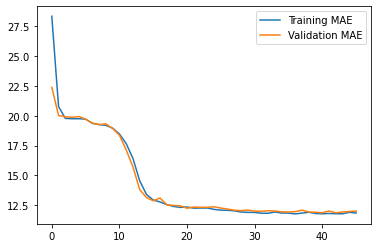

In [17]:
plt.plot(model_history.history['mae'], label='Training MAE')
plt.plot(model_history.history['val_mae'], label='Validation MAE')
plt.legend()

In [19]:
result_lstm = lstm_autoencoder.predict(X_test)
latent_lstm = lstm_encoder.predict(X_test)

2022-05-11 19:52:48.028331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.275699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.377257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.444226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.497266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.551325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 19:52:48.592323: I tensorflow/core/grappler/optimizers/cust

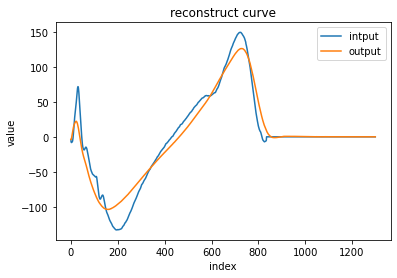

In [20]:
i = 10
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(X_test[i].reshape(1300, -1), label='intput')
plt.plot(result_lstm[i].reshape(1300,-1), label='output')
plt.legend()
plt.show()



In [25]:
loss = tf.keras.losses.mean_absolute_error(X_test, result_lstm)

In [28]:
np.array(tf.keras.losses.mean_absolute_error(X_test, result_lstm)).mean()

11.998755